<a href="https://colab.research.google.com/github/nicolas1805961/GE_reinforcement_learning/blob/master/data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import math
import random
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [26]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [27]:
patches1 = np.load("/content/drive/My Drive/patches1.npy", allow_pickle=True).astype(np.float32)
patches2 = np.load("/content/drive/My Drive/patches2.npy", allow_pickle=True).astype(np.float32)
transforms = np.load("/content/drive/My Drive/transformations.npy", allow_pickle=True)
big_images = np.load("/content/drive/My Drive/big_images.npy", allow_pickle=True).astype(np.float16)
positions = np.load("/content/drive/My Drive/patches2_pos.npy", allow_pickle=True)
transforms = transforms[..., :-1].astype(np.int8)
print(patches1.shape)
print(patches2.shape)
print(transforms.shape)
print(big_images.shape)
print(positions.shape)

(180, 150, 150)
(180, 50, 150, 150)
(180, 50, 3)
(180, 512, 512)
(180, 50, 2)


In [28]:
print(np.unique(patches1))
print(np.unique(patches2))

[0.0000000e+00 9.9406876e-05 1.9881375e-04 ... 8.6694390e-01 8.8677555e-01
 8.9220983e-01]
[0.0000000e+00 9.9406876e-05 1.9881375e-04 ... 9.3485534e-01 9.3523639e-01
 9.4156533e-01]


[4 6]
[  0 -10]
[8 7]


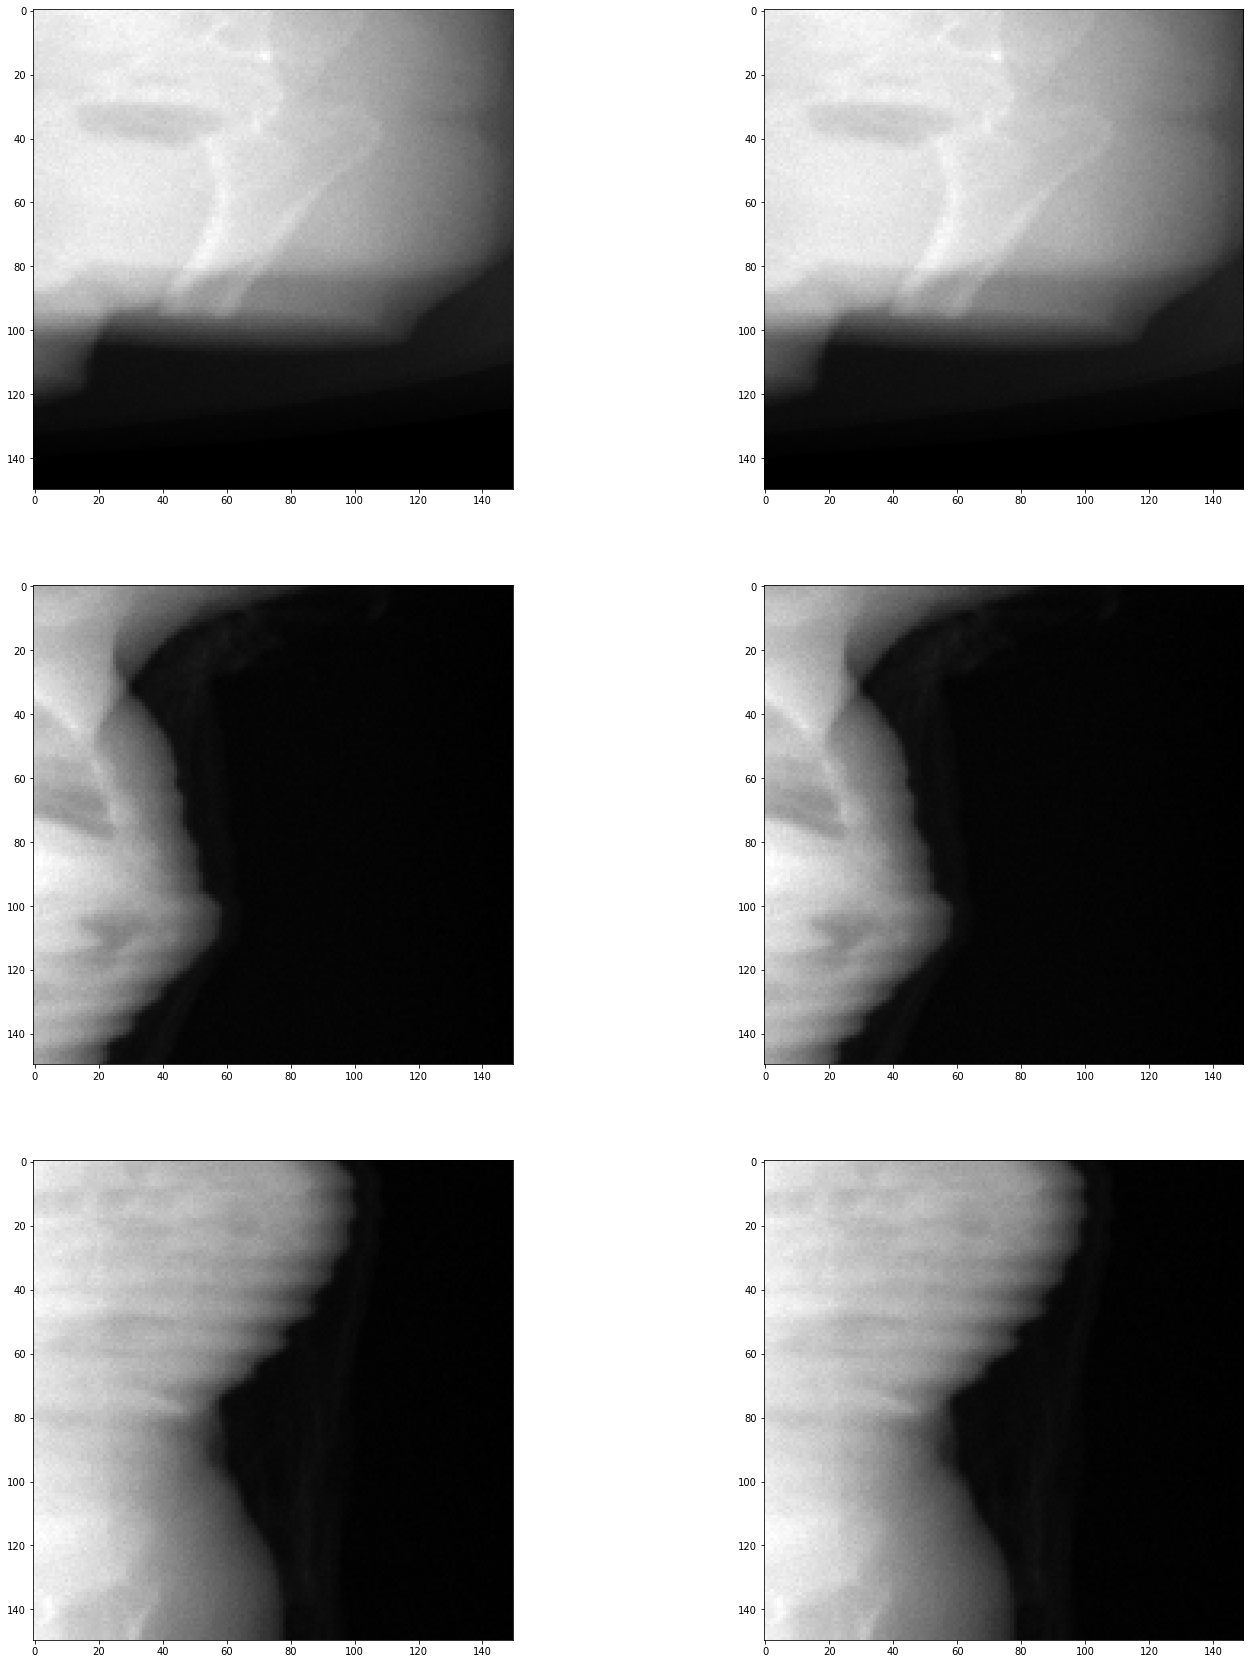

In [30]:
from skimage.transform import resize, rescale

def translate_image(big_image, position, translation):
  return big_image[position[0, 0] + translation[1]:position[0, 0] + translation[1] + 150, position[0, 1] + translation[0]:position[0, 1] + translation[0] + 150].astype(np.float32)
  #return resize(base_image, (50, 50), anti_aliasing=False)

indices = np.random.randint(0, 180, 3)
fig, ax = plt.subplots(3, 2, figsize=(24, 30))
for i, j in zip(range(3), indices):
  new = translate_image(big_images[j], positions[j, 25].reshape(1, 2), transforms[j, 25][1:])
  print(transforms[j, 25][1:])
  ax[i, 0].imshow(patches1[j], cmap='gray')
  ax[i, 1].imshow(new, cmap='gray')

In [6]:
X_list = []
Y_list = []
positions_list = []
first_images_list = []
second_images_list = []
big_images_list = []
for i in range(patches1.shape[0]):
  #patch1 = patches1[i].copy().reshape(1, 150, 150)
  #big_image = big_images[i].copy().reshape(1, 512, 512)
  batch_patch1 = np.repeat(patches1[i].reshape(1, 150, 150), 50, axis=0)
  batch_big_image = np.repeat(big_images[i].reshape(1, 512, 512), 50, axis=0)
  batch = (batch_patch1 - patches2[i]).astype(np.float32)
  batch = np.expand_dims(batch, axis=(1))
  #batch /= 255
  big_images_list.append(batch_big_image)
  first_images_list.append(batch_patch1)
  second_images_list.append(patches2[i])
  X_list.append(batch)
  Y_list.append(transforms[i])
  positions_list.append(positions[i])
X = np.concatenate(X_list)
del X_list
Y = np.concatenate(Y_list)
del Y_list
positions = np.concatenate(positions_list)
del positions_list
big_images = np.concatenate(big_images_list)
del big_images_list
first_images = np.concatenate(first_images_list)
del first_images_list
second_images = np.concatenate(second_images_list)
del second_images_list
del patches1, patches2, transforms
print(X.shape)
print(Y.shape)
print(first_images.shape)
print(second_images.shape)
print(big_images.shape)
print(positions.shape)

(9000, 1, 150, 150)
(9000, 3)
(9000, 150, 150)
(9000, 150, 150)
(9000, 512, 512)
(9000, 2)


In [7]:
print(np.unique(X))

[-0.39245832 -0.38612944 -0.3857484  ...  0.4136817   0.4149574
  0.41941416]


In [8]:
from math import cos, sin

class Q_value():
    def __init__(self, gamma, epsilon, R, number_of_outputs, rotation_step, translation_step):
        self.Tg = None
        self.gamma = gamma
        self.epsilon = epsilon
        self.R = R
        self.number_of_outputs = number_of_outputs
        self.rotation_step = rotation_step
        self.translation_step = translation_step

    def get_matrix_from_tensor(self, Tt):
        if self.number_of_outputs == 12:
            A = torch.tensor([[1, 0, 0, Tt[0]],
                            [0, cos(Tt[3]), -sin(Tt[3]), Tt[1]],
                            [0, sin(Tt[3]), cos(Tt[3]), Tt[2]],
                            [0, 0, 0, 1]])

            B = torch.tensor([[cos(Tt[4]), 0, sin(Tt[4]), 0],
                            [0, 0, 0, 0],
                            [-sin(Tt[4]), 0, cos(Tt[4]), 0],
                            [0, 0, 0, 1]])

            C = torch.tensor([[cos(Tt[5]), -sin(Tt[5]), 0, 0],
                            [sin(Tt[5]), cos(Tt[5]), 0, 0],
                            [0, 0, 1, 0],
                            [0, 0, 0, 1]])

            D = torch.matmul(A, B)
            return torch.matmul(D, C)
        
        elif self.number_of_outputs == 6:

            A = torch.tensor([[cos(Tt[0]), sin(Tt[0]), Tt[1]],
                            [-sin(Tt[0]), cos(Tt[0]), Tt[2]],
                            [0, 0, 1]])
            
            return A
            

    def get_optimal_action(self, Tt):
        at = torch.cat((torch.eye(self.number_of_outputs // 2), torch.eye(self.number_of_outputs // 2) * -1))
        at = at
        at_o_Tt = at + Tt.view((1, 3))
        norms = [self.get_distance(at_o_Tt[i, :]) for i in range(self.number_of_outputs)]
        return np.argmin(np.asarray(norms))
    
    def get_distance(self, x):
        if self.number_of_outputs == 4 or self.number_of_outputs == 6:
            inversed = x * -1
            composed = self.Tg + inversed
        else:
            matrice = self.get_matrix_from_tensor(x)
            inversed = torch.inverse(matrice)
            Tg_matrix = self.get_matrix_from_tensor(self.Tg)
            composed = torch.matmul(Tg_matrix, inversed)
        composed = composed.float()
        norm = torch.norm(composed).item()
        return norm
    
    def set_Tg(self, Tg):
        self.Tg = Tg

    def take_action(self, action, Tt):
        current_Tt = Tt.clone()
        if action == 0:
            current_Tt[action] += self.rotation_step
        elif action == 3:
            current_Tt[0] -= self.rotation_step
        elif action < self.number_of_outputs // 2:
          current_Tt[action] += self.translation_step
        else:
          current_Tt[action - (self.number_of_outputs // 2)] -= self.translation_step
        return current_Tt
    
    def get_reward(self, Tt, Tt_next):
        return self.get_distance(Tt) - self.get_distance(Tt_next)

    def get_q_value(self, Tt, action):
        Tt_next = self.take_action(action, Tt)
        reward = self.get_reward(Tt, Tt_next)
        if self.get_distance(Tt_next) < self.epsilon:
            return reward + self.R
        optimal_action_next = self.get_optimal_action(Tt_next)
        return reward + self.gamma * self.get_q_value(Tt_next, optimal_action_next)
    
    def get_q(self, number_of_images, Y_train, Tt):
      q_values = torch.zeros((number_of_images, 6)).to(device)
      for i in range(number_of_images):
          print('\r{}'.format(i), end='')
          self.set_Tg(Y_train[i])
          row = []
          for t in range(6):
              row.append(self.get_q_value(Tt, t))
          q_values[i, :] = torch.tensor(row).reshape((1, -1))
      return q_values

In [9]:
class Dataset_train(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, X, Q, transform):
        'Initialization'
        self.X = X
        self.Q = Q
        self.transform = transform

  def __len__(self):
        'Denotes the total number of samples'
        return self.X.shape[0]

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        X = self.X[index]
        #X = self.transform(X)

        # Load data and get label
        Q = self.Q[index]

        return X, Q

In [10]:
#class Dataset_test(torch.utils.data.Dataset):
#  'Characterizes a dataset for PyTorch'
#  def __init__(self, X, Y, first_images, root_image, second_translation, transform):
#        'Initialization'
#        self.X = X
#        self.Y = Y
#        self.first_images = first_images
#        #self.second_images = second_images
#        self.root = root_image
#        self.second_translation = second_translation
#        self.transform = transform
#
#  def __len__(self):
#        'Denotes the total number of samples'
#        return self.X.shape[0]
#
#  def __getitem__(self, index):
#        'Generates one sample of data'
#        # Select sample
#        X = self.X[index]
#        #X = self.transform(X)
#
#        # Load data and get label
#        Y = self.Y[index]
#        
#        one = self.first_images[index]
#        #two = self.second_images[index]
#        
#        root_image = self.root[index]
#        second_translation = self.second_translation[index]
#
#        return X, Y, one, root_image, second_translation

In [11]:
class Dataset_test(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, X, Y, first_images, second_images, positions, big_images, transform):
        'Initialization'
        self.X = X
        self.Y = Y
        self.first_images = first_images
        self.second_images = second_images
        self.positions = positions
        self.big_images = big_images
        self.transform = transform

  def __len__(self):
        'Denotes the total number of samples'
        return self.X.shape[0]

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        X = self.X[index]
        #X = self.transform(X)

        # Load data and get label
        Y = self.Y[index]
        
        one = self.first_images[index]
        two = self.second_images[index]

        position = self.positions[index]
        big_image = self.big_images[index]

        return X, Y, one, two, position, big_image

In [12]:
from sklearn.model_selection import train_test_split

transform = T.Compose([T.Normalize((0.5), (0.5))])

all_indices = list(range(X.shape[0]))
test_size_percent = 20 / X.shape[0]
test_size = test_size_percent * len(all_indices)
train_indices, test_indices = train_test_split(all_indices, test_size=test_size_percent, random_state=42)
del all_indices
X_train = torch.from_numpy(X[train_indices, ...])
X_test = torch.from_numpy(X[test_indices, ...])
del X
Y_train = Y[train_indices, ...]
Y_test = Y[test_indices, ...]
del Y
dataset_test = Dataset_test(X_test, Y_test, first_images[test_indices], second_images[test_indices], positions[test_indices], big_images[test_indices], transform)
del train_indices, first_images, X_test, Y_test, second_images, test_indices, positions, big_images
testing_generator = torch.utils.data.DataLoader(dataset_test, 1, shuffle=True)

In [13]:
print(Y_train)

[[  0   8  -6]
 [  0  10   4]
 [  0 -10  10]
 ...
 [  0 -10   4]
 [  0   8  -5]
 [  0   0  -9]]


In [14]:
q_value_1 = Q_value(0.9, 0.5, 10, 6, 10, 1)
Tt = torch.zeros(3)
q_values = q_value_1.get_q(X_train.shape[0], torch.from_numpy(Y_train), Tt)

8979

In [15]:
for i in range(10):
    print(Y_train[i])
    print(q_values[i])

[ 0  8 -6]
tensor([6.1225, 8.0700, 6.4827, 6.1225, 6.4550, 8.0380], device='cuda:0')
[ 0 10  4]
tensor([6.3649, 8.7054, 8.4986, 6.6587, 6.9580, 7.1365], device='cuda:0')
[  0 -10  10]
tensor([5.5565, 6.0378, 7.5434, 5.7923, 7.5434, 6.0378], device='cuda:0')
[ 0 -5  5]
tensor([6.3256, 6.7693, 8.4485, 6.3256, 8.4485, 6.7693], device='cuda:0')
[ 0 -2 -4]
tensor([6.9756, 7.5917, 7.5325, 6.9756, 9.3303, 9.4121], device='cuda:0')
[ 0  0 -6]
tensor([ 8.0121,  8.8679,  8.4783,  8.0121,  8.8679, 10.5905], device='cuda:0')
[ 0  9 -7]
tensor([6.0100, 7.8845, 6.3303, 6.0100, 6.3059, 7.8568], device='cuda:0')
[0 4 0]
tensor([ 8.0135, 10.7290,  8.8582,  8.0135,  8.5905,  8.8582], device='cuda:0')
[ 0  2 -5]
tensor([7.0037, 9.2476, 7.5070, 7.0037, 7.6096, 9.3839], device='cuda:0')
[ 0 -7 -8]
tensor([6.0051, 6.3332, 6.3244, 6.0051, 7.8931, 7.9032], device='cuda:0')


In [16]:
dataset_train_1 = Dataset_train(X_train, q_values, transform)
training_generator_1 = torch.utils.data.DataLoader(dataset_train_1, 32, shuffle=True)
del q_values, dataset_train_1, X_train, Y_train

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DQN(nn.Module):

    def __init__(self, d, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3)
        self.maxpool1 = nn.MaxPool2d(2)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 32, kernel_size=3)
        self.maxpool2 = nn.MaxPool2d(2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 128, kernel_size=3)
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 128, kernel_size=3)
        self.bn5 = nn.BatchNorm2d(128)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(w, f=3, p=0, s=1):
            return ((w - f + 2*p) // s) + 1
        
        def maxpool_size_out(w):
            return w // 2
        
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(maxpool_size_out(conv2d_size_out(maxpool_size_out(conv2d_size_out(w)))))))
        linear_input_size = convw * convw * 128
        
        self.head1 = nn.Linear(linear_input_size, 512)
        self.head2 = nn.Linear(512, 512)
        self.head3 = nn.Linear(512, 64)
        self.head4 = nn.Linear(64, outputs)
        
        self.linear_input_size = linear_input_size

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.bn1(self.maxpool1(self.conv1(x))))
        x = F.relu(self.bn2(self.maxpool2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = x.view(-1, self.linear_input_size)
        x = F.relu(self.head1(x))
        x = F.relu(self.head2(x))
        x = F.relu(self.head3(x))
        return self.head4(x)

#for x, y in training_generator:
#    print(x.size())
 #   net = DQN(1, x.shape[2], x.shape[3], 4).float()
#    out = net(x.float())
#    print(out.max(1)[1])
#    print(torch.argmax(out, dim=1))
#    break

In [18]:
from itertools import count

policy_net_1 = DQN(1, 150, 150, 6).to(device)
correct = 0
optimizer = optim.Adam(policy_net_1.parameters())
criterion = nn.MSELoss().to(device)
running_loss = 0.0
number_of_epoch = 200

for i_episode in range(number_of_epoch):
    for index, batch in enumerate(training_generator_1):
        x = batch[0].to(device)
        q = batch[1].to(device)

        optimizer.zero_grad()
        out = policy_net_1(x.float()).to(device)

        if torch.argmax(out) == torch.argmax(q):
          correct += 1
        
        #loss = torch.norm(out - q, dim=1).sum()
        loss = criterion(out, q)

        loss.backward()
        #for param in policy_net.parameters():
         #   param.grad.data.clamp_(-1, 1)
        optimizer.step()
        
        running_loss += loss.item()
    accuracy = correct / (index + 1)
    correct = 0
    # print statistics
    print("Epoch: {} Loss: {} Accuracy: {}".format((i_episode + 1), running_loss / (i_episode + 1), accuracy))


Epoch: 1 Loss: 795.7803572416306 Accuracy: 0.03914590747330961
Epoch: 2 Loss: 519.5280527472496 Accuracy: 0.13523131672597866
Epoch: 3 Loss: 410.2514582872391 Accuracy: 0.13167259786476868
Epoch: 4 Loss: 342.77912105992436 Accuracy: 0.14590747330960854
Epoch: 5 Loss: 299.5035128086805 Accuracy: 0.1601423487544484
Epoch: 6 Loss: 269.08321313808364 Accuracy: 0.19572953736654805
Epoch: 7 Loss: 244.1194535823805 Accuracy: 0.19217081850533807
Epoch: 8 Loss: 222.4408475374803 Accuracy: 0.21352313167259787
Epoch: 9 Loss: 206.93148024131855 Accuracy: 0.18505338078291814
Epoch: 10 Loss: 192.81418555676936 Accuracy: 0.2775800711743772
Epoch: 11 Loss: 180.63462031632662 Accuracy: 0.3274021352313167
Epoch: 12 Loss: 169.8431092246125 Accuracy: 0.3487544483985765
Epoch: 13 Loss: 161.21824057973348 Accuracy: 0.3914590747330961
Epoch: 14 Loss: 154.3551105428487 Accuracy: 0.3487544483985765
Epoch: 15 Loss: 146.94261669615904 Accuracy: 0.4128113879003559
Epoch: 16 Loss: 140.94888185127638 Accuracy: 0.45

In [19]:
torch.save(policy_net_1.state_dict(), "/content/drive/My Drive/model.pt")

In [20]:
model = DQN(1, 150, 150, 6).to(device)
model.load_state_dict(torch.load("/content/drive/My Drive/model.pt"))
model.eval()

DQN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (head1): Linear(in_features=115200, out_features=512, bias=True)

In [21]:
from skimage.measure import label, regionprops, approximate_polygon, find_contours

def get_perimeter(image):
    img = image.copy()
    binary = (img > 20)
    perimeter = 0
    contour = sorted(find_contours(binary, 0), key=lambda x: x.shape[0])[-1]
    perimeter = approximate_polygon(contour, tolerance=0)
    return perimeter

In [38]:
print(torch.unique(torch.tensor([[1, 2, 3],
              [4, 5, 6], 
              [4, 5, 6]]), dim=0).size(0))

2


In [44]:
from torchvision.transforms.functional import normalize, to_pil_image, to_tensor, affine


q_value = Q_value(0.9, 0.5, 10, 6, 10, 1)
list_of_first_images = []
policy_nets = [model]
q_values = [q_value]
correct = 0
total = 20
number_of_steps = 200
list_of_examples = []
with torch.no_grad():
    for data in testing_generator:
        list_of_frames = []
        print('***************************')
        x = data[0].to(device)
        y = data[1]
        first_image = data[2].reshape(150, 150)
        list_of_first_images.append(first_image)
        second_image = to_pil_image(data[3].int())
        position = data[4]
        big_image = data[5].numpy().reshape(512, 512)
        Tt = torch.zeros((number_of_steps, 3), dtype=torch.int16)
        out_array = torch.zeros((number_of_steps, 6), dtype=torch.float32)
        print(y)
        print('/*/*/*/*/*/*/*/*/*/*/*/*/*/*')
        j = 0
        while j < number_of_steps - 1:
            out = model(x.float())
            action = torch.argmax(out, dim=1)
            Tt[j + 1, :] = q_value.take_action(action, Tt[j, :])
            out_array[j + 1] = out
            if torch.unique(Tt[:j + 2], dim=0).size(0) == torch.unique(Tt[:j + 1], dim=0).size(0):
              if torch.dist(Tt[j + 1, :].float(), y).item() <= 1:
                  correct += 1
              if torch.sum(out_array[j + 1]) < torch.sum(out_array[j]):
                Tt[j + 1, :] = torch.zeros((1, 3), dtype=torch.int16)
              break
            translation = np.array([Tt[j + 1, 1].item(), Tt[j + 1, 2].item()])
            if np.amax(position.numpy() + translation[::-1]) + 150 == 511 or np.amin(position.numpy() + translation[::-1]) == 0:
              break
            current_image = translate_image(big_image, position, translation)
            #current_image = to_tensor(affine(second_image, angle=Tt[j + 1, 0].item(), translate=translation, scale=1, shear=0))
            list_of_frames.append(current_image.reshape((150, 150)))
            diff = first_image - current_image
            x = diff.view(1, 1, 150, 150).to(device)
            j += 1
        stack_of_frames = np.stack(list_of_frames)
        #stack_of_frames = np.pad(stack_of_frames, ((0, number_of_steps - stack_of_frames.shape[0]), (0, 0), (0, 0)))
        list_of_examples.append(stack_of_frames)
        mask = Tt.eq(torch.zeros((number_of_steps, 3))).all(dim=1)
        Tt = Tt[~mask]
        print(Tt)
    print('accuracy {}%'.format(100 * correct / total))

***************************
tensor([[ 0,  2, -9]], dtype=torch.int8)
/*/*/*/*/*/*/*/*/*/*/*/*/*/*
tensor([[ 0,  0, -1],
        [ 0,  0, -2],
        [ 0,  0, -3],
        [ 0,  0, -4],
        [ 0,  0, -5],
        [ 0,  1, -5],
        [ 0,  1, -6],
        [ 0,  1, -7],
        [ 0,  2, -7],
        [ 0,  2, -8],
        [ 0,  2, -9]], dtype=torch.int16)
***************************
tensor([[0, 8, 2]], dtype=torch.int8)
/*/*/*/*/*/*/*/*/*/*/*/*/*/*
tensor([[0, 1, 0],
        [0, 2, 0],
        [0, 3, 0],
        [0, 4, 0],
        [0, 5, 0],
        [0, 5, 1],
        [0, 6, 1],
        [0, 7, 1],
        [0, 7, 2],
        [0, 8, 2],
        [0, 8, 3],
        [0, 8, 2]], dtype=torch.int16)
***************************
tensor([[ 0, -1,  1]], dtype=torch.int8)
/*/*/*/*/*/*/*/*/*/*/*/*/*/*
tensor([[ 0,  0,  1],
        [ 0, -1,  1],
        [ 0, -1,  2],
        [ 0, -1,  1]], dtype=torch.int16)
***************************
tensor([[ 0,  4, -9]], dtype=torch.int8)
/*/*/*/*/*/*/*/*/*/*/*

In [ ]:
print(list_of_examples[0].shape)
print(list_of_first_images[0].shape)

In [ ]:
index = np.argmax([x.shape[0] for x in list_of_examples])
frames = list_of_examples[0][:20, ...]
#perimeter = perimeters[0]
fig, ax = plt.subplots(frames.shape[0], 2, figsize=(32, 10*frames.shape[0]))
for i in range(frames.shape[0]):
    #ax[i].plot(perimeter[:, 1], perimeter[:, 0], '-r', linewidth=1)
    ax[i, 0].imshow(frames[i], cmap='gray')
    ax[i, 1].imshow(list_of_first_images[0], cmap='gray')

In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.backends.backend_pdf

pdf = matplotlib.backends.backend_pdf.PdfPages("/content/output.pdf")
library = np.concatenate(list_of_examples)
#perimeters_thresh = [x.shape[0] for x in list_of_examples]
#cum_thresh = np.cumsum(perimeters_thresh)
j = 0
i = 0
while i < library.shape[0]:
  #if i >= cum_thresh[j]:
  #  j += 1
  #perimeter = perimeters[j]
  fig, ax = plt.subplots(1, 1, figsize=(8, 8))
  #ax.plot(perimeter[:, 1], perimeter[:, 0], '-r', linewidth=1)
  ax.imshow(library[i], cmap='gray')
  i += 1
  pdf.savefig(fig, bbox_inches='tight')
  plt.close(fig)
pdf.close()

#library = np.stack(list_of_examples)
#for i in range(10):
#    interact(display, img=fixed(library[i, ...]), perimeters=fixed(perimeters[i]), slice_number=widgets.IntSlider(min=0, max=library[i, ...].shape[0] - 1, step=1, value=0))